#Pecan validation analysis

Here we perform analysis on the model vs ground truth data for thermal and occupancy consumption. We contrast two models:
* ground truth thermal response: a locally-weighted regression model using separately-monitored HVAC and temperature
* the HMM thermal model

##Initializations

In [67]:
rm(list = ls())
options(error = recover)
library('segmented')
library('lubridate')
library('ggplot2')

In [68]:
setwd("~/EnergyAnalytics/thermal_profiles/")
#source('validator/metrics.r')
source('validator/plot_metrics.r')

In [69]:
DATA_PATH = '~/S3L_server/energy-data/pecan_street/usage-select/'
DUMP_PATH = '~/S3L_server/energy-data/pecan_street/models_new/'
PLOT_PATH = '~/S3L_server/plots/pecan-street-new/'
MODEL_PATH= '~/S3L_server/energy-data/pecan_street/models_new/'

Paths to original data

In [70]:
# load user names
user_names = read.csv('~/S3L_server/energy-data/pecan_street/metadata/user_names_ids.csv')
user_names$X = NULL

# list all data files
files    = list.files(path=DATA_PATH, full.names = T, recursive = T)
files_01 = files[grep('01min',files)]
files_15 = files[grep('15min',files)]
files_60 = files[grep('60min',files)]

# extract ID
users_df = data.frame(UID = as.character(sapply(files_60, function(s) strsplit(tail(strsplit(s, '/')[[1]], 1), '\\.')[[1]][1])))
rownames(users_df) = NULL
    
# build original data sources dataframe
users_df = merge(users_df, user_names, by.x="UID", by.y="ID")
users_df['01min'] = files_01
users_df['15min'] = files_15
users_df['60min'] = files_60
users_df = melt(users_df, id=c("UID","name"))
names(users_df)[c(3,4)] = c("grain", "file_orig")  

In [71]:
users_df[1,]

,UID,name,grain,file_orig
1,1069,Edd,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1069.csv


Paths to thermal models data

In [72]:
# models 
files = list.files(path=MODEL_PATH, pattern="*decoded", full.names = T, recursive = T)
model_paths  = lapply(files, function(x) {
    tmp = tail(strsplit(x, '/')[[1]],n=2)
    res = tmp[1]
    nfo = strsplit(tmp[2], "_")[[1]]
    uid = nfo[1]; name = nfo[2]; 
    return(c(uid,name,res,x))
})
model_paths = data.frame(do.call('rbind', model_paths))
if (length(model_paths)>0) names(model_paths) <- c("UID", "name", "grain", "file_model")


In [73]:
head(model_paths)

,UID,name,grain,file_model
1,1069,Edd,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/15min/1069_Edd_decoded.RData
2,1069,Edd,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/60min/1069_Edd_decoded.RData
3,1086,Emery,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1086_Emery/15min/1086_Emery_decoded.RData
4,1086,Emery,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1086_Emery/60min/1086_Emery_decoded.RData
5,1105,Grant,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1105_Grant/15min/1105_Grant_decoded.RData
6,1105,Grant,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1105_Grant/60min/1105_Grant_decoded.RData


In [74]:
head(users_df)

,UID,name,grain,file_orig
1,1069,Edd,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1069.csv
2,1086,Emery,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1086.csv
3,1105,Grant,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1105.csv
4,114,James,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/114.csv
5,1167,Jerome,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1167.csv
6,1169,George,01min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//01min/1169.csv


In [75]:
info_files = merge(model_paths, users_df, by=c("UID", "name", "grain"))

In [76]:
dim(info_files); dim(model_paths); dim(users_df)

[1] 336   5

[1] 336   4

[1] 1098    4

In [77]:
head(info_files)

,UID,name,grain,file_model,file_orig
1,1069,Edd,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/15min/1069_Edd_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/1069.csv
2,1069,Edd,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1069_Edd/60min/1069_Edd_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1069.csv
3,1086,Emery,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1086_Emery/15min/1086_Emery_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/1086.csv
4,1086,Emery,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1086_Emery/60min/1086_Emery_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1086.csv
5,1105,Grant,15min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1105_Grant/15min/1105_Grant_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//15min/1105.csv
6,1105,Grant,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_new//1105_Grant/60min/1105_Grant_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1105.csv


In [82]:
format_data = function(homeData) {
    fillInTheBlanks <- function(S) {
        L <- !is.na(S)
        c(S[L][1], S[L])[cumsum(L)+1]
    }
    # some response observations are NA, replace them with last ok observation
    homeData$use = fillInTheBlanks(homeData$use)

    # remove observations with NAs in response
    idx.na = is.na(homeData$use)
    if (sum(idx.na)>0) homeData = homeData[-idx.na,]

    # temperature above reference
    homeData$TemperatureD = homeData$TemperatureF - 65

    # format data as expected by the HMM package
    cur_data = subset(homeData, select = c('date', 'use'))
    names(cur_data)[2] = 'obs'
    cur_data$date = as.character(cur_data$date)
    cur_covar = subset(homeData, select = c('date', 'TemperatureF', 'TemperatureD'))
    cur_covar$date = as.character(cur_covar$date)
    cur_month     = month(cur_data$date)
    cur_covar$TemperatureDWinter = cur_covar$TemperatureD * (cur_month %in% c(0,1,2,3,10,11,12))

    return(list(cur_data, cur_covar))
}


In [84]:
res = format_data(df)

In [88]:
dim(res[[1]]); dim(res[[2]]); dim(df)

[1] 78686     2

[1] 78686     4

[1] 78686     8

##Load processed thermal regimes data

In [157]:
thermal_lst = list()
for (i in 1:nrow(info_files)) {
    print(paste("Processing file", i, "of", nrow(info_files)))
    row <- info_files[i,]
    load(as.character(as.character(row$file_model)));
    df = read.csv(as.character(row$file_orig))

    if (length(data$states) != nrow(df)) next
        
    # access data    
    nStates= data$nStates
    df$state = data$states; 
    df$TemperatureD = df$TemperatureF - 65
    resp   = data$response   
    tran   = data$transition
    tran   = lapply(unique(tran$From), function(s) {d = subset(tran, To ==s); d$From = d$To = NULL; rownames(d) = 1:nrow(d); return(d)})

    # check for consistency
    if (class(resp$stderr) == 'list') {
      idx.nan = which(sapply(resp$stderr, length) < 2)    
      z = c(0,0,0); names(z) = c('(Intercept)', 'TemperatureD')
      for (i in 1:length(idx.nan)) {
        tmp = resp$stderr[[idx.nan[i]]]
        z[names(tmp)] = tmp
        resp$stderr[[idx.nan[i]]] = z
      }
      resp$stderr = as.data.frame(do.call('cbind', resp$stderr))
      names(resp$stderr) = 1:ncol(resp$stderr)
    }

    # format model parameters for easy analysis access
    volatility = lapply(1:nStates, function(s) { z = c(mu = 0, sd = resp$stdev[s]); names(z) = c('mu', 'sd'); z})
    baseload   = lapply(1:nStates, function(s) { z = c(mu = resp$means['(Intercept)', s], sd = resp$stderr['(Intercept)', s]); names(z) = c('mu', 'sd'); z})
    response   = lapply(1:nStates, function(s) c(mu = resp$means['TemperatureD', s], sd = as.numeric(resp$stderr['TemperatureD', s])))

    thermal_lst[[as.character(row$name)]][[as.character(row$grain)]] = list(volatility = volatility, baseload = baseload, response = response, tran = tran, data = df)
}

[1] "Processing file 1 of 336"
[1] "Processing file 2 of 336"
[1] "Processing file 3 of 336"
[1] "Processing file 4 of 336"
[1] "Processing file 5 of 336"
[1] "Processing file 6 of 336"
[1] "Processing file 7 of 336"
[1] "Processing file 8 of 336"
[1] "Processing file 9 of 336"
[1] "Processing file 10 of 336"
[1] "Processing file 11 of 336"
[1] "Processing file 12 of 336"
[1] "Processing file 13 of 336"
[1] "Processing file 14 of 336"
[1] "Processing file 15 of 336"
[1] "Processing file 16 of 336"
[1] "Processing file 17 of 336"
[1] "Processing file 18 of 336"
[1] "Processing file 19 of 336"
[1] "Processing file 20 of 336"
[1] "Processing file 21 of 336"
[1] "Processing file 22 of 336"
[1] "Processing file 23 of 336"
[1] "Processing file 24 of 336"
[1] "Processing file 25 of 336"
[1] "Processing file 26 of 336"
[1] "Processing file 27 of 336"
[1] "Processing file 28 of 336"
[1] "Processing file 29 of 336"
[1] "Processing file 30 of 336"
[1] "Processing file 31 of 336"
[1] "Processing f

In [158]:
names(thermal_lst)

[1] "Edd"       "Emery"     "Grant"     "James"     "Jerome"    "Frank"    
  [7] "Thomas"    "Max"       "Henry"     "Mose"      "Steve"     "Gordon"   
 [13] "Robert"    "Abe"       "Pete"      "Chris"     "Clark"     "Gustave"  
 [19] "Orville"   "Lorenzo"   "Bruce"     "Walter"    "Marcus"    "Preston"  
 [25] "Arthur"    "Albert"    "Samuel"    "Dock"      "David"     "Louis"    
 [31] "Richard"   "Donald"    "Jackson"   "Cecil"     "Daniel"    "Barney"   
 [37] "Delbert"   "Edmond"    "Anderson"  "Ernest"    "Oscar"     "Lewis"    
 [43] "Peter"     "Benjamin"  "Frederick" "Christian" "Alfred"    "Jefferson"
 [49] "Sam"       "Luke"      "Neal"      "Burt"      "Ike"       "Jacob"    
 [55] "Elmer"     "Carl"      "Tony"      "Conrad"    "Matt"      "Riley"    
 [61] "Vincent"   "Emory"     "Martin"    "Michael"   "Bert"      "Nick"     
 [67] "Herman"    "Francis"   "Ezra"      "Harvey"    "Green"     "Earl"     
 [73] "Juan"      "Clifton"   "Ed"        "Claude"    "Porter"    "Arnold"   
 [79] "Ben"       "Bud"       "Jeremiah"  "Taylor"    "Paul"      "Roland"   
 [85] "Spencer"   "Burton"    "Don"       "Emmet"     "Edgar"     "Gustav"   
 [91] "Louie"     "Otto"      "Luther"    "Morgan"    "Van"       "Ambrose"  
 [97] "Chauncey"  "Elisha"    "Theodore"  "Ferdinand" "Clyde"     "General"  
[103] "Julian"    "Mitchell"  "Allie"     "Josh"      "Judson"    "Lyman"    
[109] "Floyd"     "Napoleon"  "Jack"      "Pedro"     "Leonard"   "Horace"   
[115] "Marion"    "Philip"    "Berry"     "Archie"    "Dewitt"    "Ervin"    
[121] "Forest"    "Lynn"      "Pink"      "Ruben"     "Sanford"   "Raymond"  
[127] "Warren"    "Douglas"   "Ole"       "Omer"      "Ulysses"   "Alex"     
[133] "Walker"    "Wilbert"   "Leo"       "Benjiman"  "Jonas"     "Major"    
[139] "Abner"     "Archibald" "Sidney"    "Caleb"     "Dudley"    "Granville"
[145] "King"      "Mary"      "Merton"    "Bernard"   "Antonio"   "Bennie"   
[151] "Dan"       "Carroll"   "Josiah"    "Alonzo"    "Johnnie"   "Gust"     
[157] "Melvin"    "Loren"     "Felix"     "Johnny"    "Lawson"    "Grover"   
[163] "Nicholas"  "Newton"    "Rolla"     "Edmund"    "Jeff"      "Lon"      
[169] "Ollie"     "Russell"   "Steven"

In [163]:
thermal_lst[['Edd']][['15min']][['baseload']]

[[1]]
         mu          sd 
0.336191770 0.003333254 

[[2]]
        mu         sd 
0.53289555 0.00691276 

[[3]]
          mu           sd 
0.0684087419 0.0002107978 

[[4]]
          mu           sd 
0.1034964165 0.0003725584

##Estimate "ground truth" thermal response

In [52]:
for (i in 1:1){ #nrow(info_files)) {
    row <- info_files[i,]
    df = read.csv(as.character(row$file_orig))
    df$HVAC = df$HV + df$AC
    df$TemperatureD = df$TemperatureF - 65
    fit = loess(HVAC ~ TemperatureD, data=df)
}

In [55]:
summary(fit)

Call:
loess(formula = HVAC ~ TemperatureD, data = df)

Number of Observations: 17852 
Equivalent Number of Parameters: 4.77 
Residual Standard Error: 0.1398 
Trace of smoother matrix: 5.2 

Control settings:
  normalize:  TRUE 
  span	    :  0.75 
  degree   :  2 
  family   :  gaussian
  surface  :  interpolate	  cell = 0.2

In [165]:
str(df)

'data.frame':	2664 obs. of  9 variables:
 $ date        : Factor w/ 2664 levels "2013-12-10 16:00:00",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ use         : num  1.351 1.481 1.241 0.283 0.326 ...
 $ AC          : num  0.2348 0.000667 0 0 0 ...
 $ HV          : num  0.02382 0.00833 0.0081 0.00998 0.00943 ...
 $ user        : num  0 0.000667 0.16685 0 0 ...
 $ nonHVAC     : num  1.092 1.472 1.233 0.273 0.317 ...
 $ TemperatureF: num  46.2 44.9 41.9 39.3 37.3 ...
 $ state       : num  1 1 1 2 2 2 3 2 2 2 ...
 $ TemperatureD: num  -18.8 -20.1 -23.1 -25.7 -27.7 ...


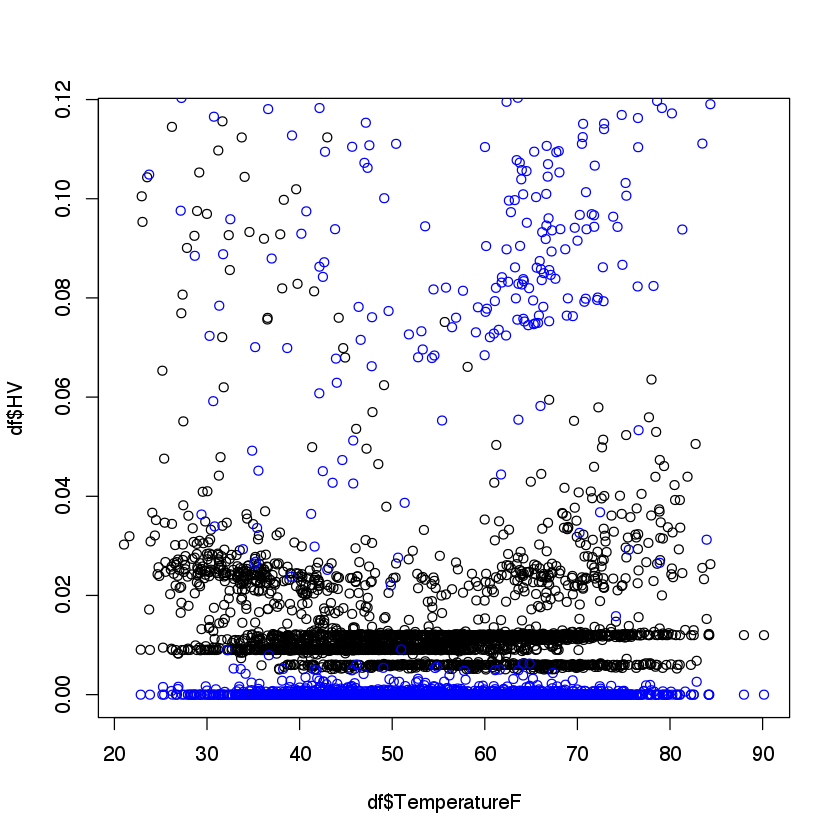

In [168]:
plot(df$TemperatureF, df$HV)
points(df$TemperatureF, df$AC, col="blue")

In [181]:
dff = subset(df, AC>0)

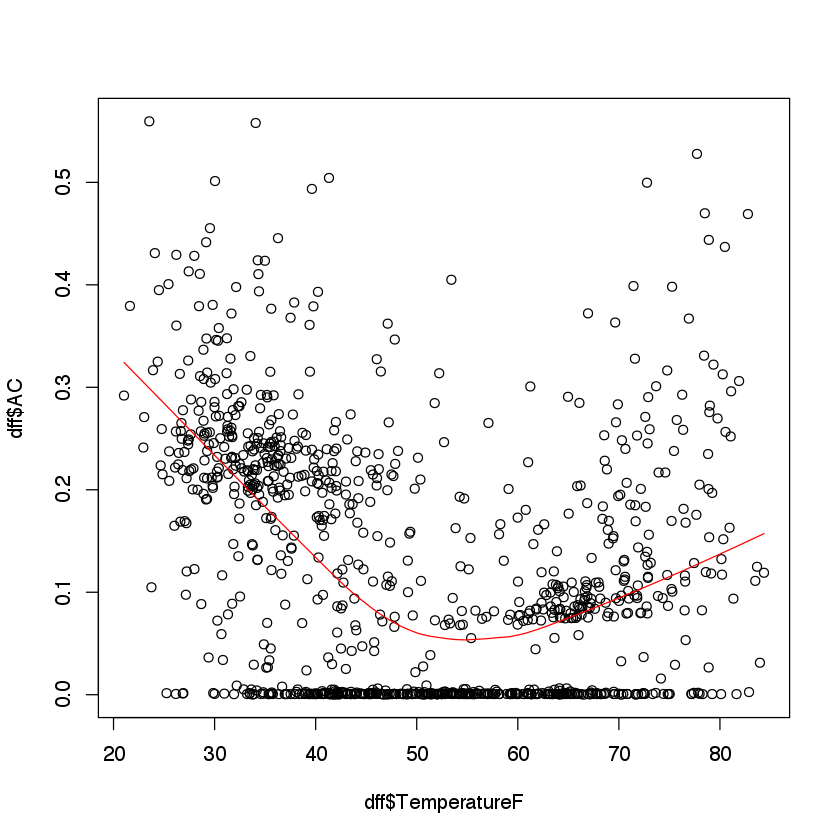

In [182]:
plot(dff$TemperatureF, dff$AC)
lines(lowess(dff$TemperatureF, dff$AC), col = 2)

In [171]:
lowess(df$TemperatureF, df$AC)

$x
   [1] 21.03667 21.62333 22.84533 22.95200 23.03333 23.53867 23.75300 23.83833
   [9] 23.90833 24.09000 24.37267 24.49033 24.66367 24.77133 24.84833 25.17900
  [17] 25.24867 25.37333 25.43800 25.50533 25.51333 26.02533 26.09233 26.16567
  [25] 26.17400 26.21367 26.21917 26.26033 26.41000 26.45333 26.56033 26.61167
  [33] 26.63967 26.65500 26.71833 26.74900 26.83333 26.85167 26.86833 26.90833
  [41] 27.01167 27.04800 27.15933 27.21033 27.22700 27.24133 27.29900 27.36333
  [49] 27.38800 27.38967 27.44000 27.44367 27.49567 27.54467 27.63667 27.66833
  [57] 27.67633 27.83500 27.90867 27.93867 27.95500 27.99067 28.00333 28.16033
  [65] 28.29800 28.31700 28.41917 28.45700 28.54000 28.55967 28.64133 28.64167
  [73] 28.67833 28.68333 28.75500 28.89500 28.90133 28.90367 28.90700 28.92800
  [81] 28.95967 28.96667 29.00000 29.00667 29.15333 29.16167 29.18667 29.19167
  [89] 29.24467 29.25133 29.25200 29.26500 29.26533 29.28700 29.36133 29.40533
  [97] 29.43400 29.52333 29.54067 29.61467 29.71533 29.73667 29.76367 29.80833
 [105] 29.81000 29.83400 29.86567 29.91667 29.99067 29.99200 29.99967 30.00267
 [113] 30.04167 30.05300 30.12500 30.15533 30.21000 30.23333 30.23767 30.24167
 [121] 30.24667 30.25933 30.27500 30.27600 30.31067 30.33633 30.41267 30.41600
 [129] 30.45833 30.47400 30.56200 30.67000 30.67367 30.68000 30.75000 30.80833
 [137] 30.82600 30.95033 30.95933 30.99500 31.06633 31.17833 31.18500 31.21800
 [145] 31.23667 31.24167 31.27167 31.28267 31.28833 31.30333 31.31333 31.31667
 [153] 31.32333 31.35000 31.42833 31.46167 31.56733 31.56767 31.56833 31.64333
 [161] 31.66833 31.66867 31.71833 31.73000 31.74033 31.75000 31.80500 31.82133
 [169] 31.84233 31.85217 31.87600 31.92400 31.93033 31.97333 32.04500 32.06167
 [177] 32.07767 32.13200 32.19033 32.19167 32.23533 32.34667 32.35300 32.38167
 [185] 32.43967 32.45167 32.46667 32.49367 32.51867 32.65100 32.65833 32.66467
 [193] 32.70100 32.72167 32.82967 32.87556 32.92467 33.05500 33.06300 33.07500
 [201] 33.13700 33.18333 33.20000 33.21167 33.23333 33.25100 33.28500 33.29533
 [209] 33.29833 33.30000 33.30000 33.32967 33.37667 33.40650 33.43333 33.47500
 [217] 33.48000 33.52167 33.53711 33.54167 33.54333 33.56500 33.63167 33.64000
 [225] 33.67967 33.68333 33.68967 33.70267 33.73700 33.73833 33.75000 33.77867
 [233] 33.78467 33.81667 33.81767 33.87667 33.87967 33.90367 33.90833 33.91333
 [241] 33.95767 34.01667 34.04333 34.06533 34.09800 34.09900 34.16667 34.17167
 [249] 34.19167 34.20667 34.20700 34.21133 34.23167 34.23433 34.23467 34.25200
 [257] 34.26833 34.27550 34.33333 34.34167 34.36467 34.38433 34.39267 34.40333
 [265] 34.40500 34.50333 34.51867 34.56367 34.56800 34.57200 34.58167 34.63167
 [273] 34.69400 34.76667 34.76750 34.77167 34.80933 34.82067 34.85000 34.86167
 [281] 34.87367 34.94867 34.98000 35.10567 35.10933 35.11367 35.16767 35.17467
 [289] 35.17500 35.18500 35.20200 35.21833 35.25000 35.25300 35.26667 35.26833
 [297] 35.27000 35.30000 35.31800 35.33133 35.33333 35.34167 35.34867 35.38200
 [305] 35.39167 35.39267 35.40633 35.41033 35.44867 35.48333 35.49033 35.50967
 [313] 35.53467 35.54233 35.55100 35.55667 35.55833 35.59033 35.60333 35.61767
 [321] 35.62633 35.62867 35.63433 35.65833 35.67400 35.71967 35.76000 35.76833
 [329] 35.79033 35.83967 35.85800 35.86367 35.87000 35.88667 35.90000 35.92033
 [337] 35.95000 35.99200 36.01233 36.04267 36.08767 36.08867 36.13500 36.14600
 [345] 36.15000 36.15467 36.18100 36.25433 36.27367 36.28633 36.29000 36.30000
 [353] 36.33800 36.34167 36.35300 36.38833 36.47167 36.47667 36.47833 36.49267
 [361] 36.51500 36.51867 36.54508 36.55500 36.55767 36.58433 36.58667 36.60333
 [369] 36.68033 36.72267 36.73733 36.77700 36.80933 36.82500 36.87167 36.87600
 [377] 36.88300 36.94467 36.95200 36.98433 37.01833 37.07167 37.07500 37.13500
 [385] 37.14967 37.16000 37.18500 37.19567 37.23833 37.24900 37.28167 37.31700
 [393] 37.33667 37.37600 37.41367 37.45000 37.46000 37.50189 37.51500 37.51667
 [401] 37.52683 37.52833 37.58700 37.59167 37.6